In [14]:
import uproot
import awkward
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from tqdm import tqdm_notebook as tqdm

In [15]:
def plotHist(axes, data, xlabel, ylabel, title, Nbins = 100, range=None, xlog=False, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if xlog:
        axes.set_xscale('log')
        Nbins = np.logspace(np.log10(data.min()),np.log10(data.max()),Nbins)
    return axes.hist(data, bins=Nbins, range=range, histtype='step', log=ylog); 
    
def plotHist_absxlog(axes, data, xlabel, ylabel, title, Nbins = 100, ylog=False):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.set_xscale('log')
    Nbins = np.logspace(np.log10(np.abs(data).min()),np.log10(np.abs(data).max()),Nbins)
    axes.hist(data, bins=Nbins, histtype='step', log=ylog); 
    
def plotHist_layers(data, ylabel, title, xlabel="Layer", log=True):
    fig,axes = plt.subplots(figsize=(10, 7));
    axes.set_xlabel(xlabel)
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    axes.hist(data, range=(0,60), bins=np.arange(62)-0.5, log=log, histtype='step', linewidth = '1.5');
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    return fig

In [16]:
#fname = '~/Downloads/hgcalNtuple.root'
#fname = 'hgcalNtuple_5k.root'
fname = 'hgcalNtuple_April25.root'
rootfile = uproot.open(fname)['ana']['hgc']
figs = []

In [17]:
rootfile.keys()


[b'event',
 b'lumi',
 b'run',
 b'vtx_x',
 b'vtx_y',
 b'vtx_z',
 b'genpart_eta',
 b'genpart_phi',
 b'genpart_pt',
 b'genpart_energy',
 b'genpart_dvx',
 b'genpart_dvy',
 b'genpart_dvz',
 b'genpart_ovx',
 b'genpart_ovy',
 b'genpart_ovz',
 b'genpart_mother',
 b'genpart_exphi',
 b'genpart_exeta',
 b'genpart_exx',
 b'genpart_exy',
 b'genpart_fbrem',
 b'genpart_pid',
 b'genpart_gen',
 b'genpart_reachedEE',
 b'genpart_fromBeamPipe',
 b'genpart_posx',
 b'genpart_posy',
 b'genpart_posz',
 b'gen_eta',
 b'gen_phi',
 b'gen_pt',
 b'gen_energy',
 b'gen_charge',
 b'gen_pdgid',
 b'gen_status',
 b'gen_daughters',
 b'rechit_eta',
 b'rechit_phi',
 b'rechit_pt',
 b'rechit_energy',
 b'rechit_x',
 b'rechit_y',
 b'rechit_z',
 b'rechit_time',
 b'rechit_thickness',
 b'rechit_layer',
 b'rechit_wafer_u',
 b'rechit_wafer_v',
 b'rechit_cell_u',
 b'rechit_cell_v',
 b'rechit_detid',
 b'rechit_isHalf',
 b'rechit_flags',
 b'rechit_cluster2d',
 b'rechit_radius',
 b'cluster2d_eta',
 b'cluster2d_phi',
 b'cluster2d_pt',
 b

In [18]:
rechit = rootfile.arrays([b'rechit_thickness', b'rechit_energy',  b'rechit_layer',  b'rechit_time', \
                          b'rechit_x', b'rechit_y', b'rechit_z', b'rechit_eta', b'rechit_phi'])
rechit[b'rechit_x'].content[rechit[b'rechit_z'].content < 0] *= -1
NEvents = rechit[b'rechit_z'].shape[0]
simcluster = rootfile.arrays([b'simcluster_hits_indices',  b'simcluster_energy', b'simcluster_eta', b'simcluster_phi', b'simcluster_layers', b'simcluster_pid'])

In [19]:
sim_indices = awkward.fromiter(simcluster[b'simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


In [20]:
simcluster_rechit_cut = 3 #min no. of rechits in simcluster requirement (exclusive)
simcluster_mask = awkward.JaggedArray.fromcounts(valid_sim_indices.counts,valid_sim_indices.flatten().counts > simcluster_rechit_cut)
simcluster_mask = simcluster_mask & (simcluster[b'simcluster_energy'] > 1.0)
valid_sim_indices = valid_sim_indices[simcluster_mask]
for key, value in simcluster.items():
    if (key == b'simcluster_hits_indices'): continue
    simcluster[key] = awkward.fromiter(value)[simcluster_mask]

In [21]:
valid_sim_indices_eventlevel = valid_sim_indices.flatten(1)
valid_sim_indices_eventlevel = awkward.fromiter(map(np.unique, valid_sim_indices_eventlevel))

In [22]:
simmatched_rechit = {}
for key, value in rechit.items():
    simmatched_rechit[key] = value[valid_sim_indices_eventlevel]

In [23]:
def rewrap_into_simcluster_structure(filelevel_array):
    return awkward.JaggedArray.fromcounts(valid_sim_indices.counts,\
        (awkward.JaggedArray.fromcounts(valid_sim_indices.content.counts, filelevel_array)))

rechit_simcluster = {}
select_rechit_simcluster = [b'rechit_energy', b'rechit_layer', b'rechit_eta', b'rechit_phi', b'rechit_time']
for key, value in rechit.items():
    if key not in select_rechit_simcluster: continue
    rechit_simcluster[key] = value[valid_sim_indices.flatten(1)]
    rechit_simcluster[key] = rewrap_into_simcluster_structure(rechit_simcluster[key].content)
    
#corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy'] * rewrap_into_simcluster_structure(np.take(absorber_weights,rechit_simcluster[b'rechit_layer'].content.content))
corrected_rechit_simcluster_energy = rechit_simcluster[b'rechit_energy']

In [24]:
def plotRechitEnergy_Thickness(thickness, rechit_energy, rechit_thickness, title_target):
    title = '%s Energy Distribution for %d um' % (title_target, thickness)
    if thickness == 100:
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 99.0) & (rechit_thickness.flatten() < 121.0)]
#       e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 99.0) & (rechit_pd[b'rechit_thickness'] < 121.0)][b'rechit_energy']
    if thickness == 200:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 199.0) & (rechit_pd[b'rechit_thickness'] < 201.0)][b'rechit_energy']
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 199.0) & (rechit_thickness.flatten() < 201.0)]
    if thickness == 300:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 299.0) & (rechit_pd[b'rechit_thickness'] < 301.0)][b'rechit_energy']
        e = rechit_energy.flatten()[(rechit_thickness.flatten() > 299.0) & (rechit_thickness.flatten() < 301.0)]
    if thickness == -1:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 301.0)][b'rechit_energy']
        e = rechit_energy.flatten()[rechit_thickness.flatten() > 301.0]
        title = "%s Energy Distribution for Scintillator Backing Calorimeter" % (title_target)
    
    fig = plt.figure(figsize=(17,5));
    ax1 = fig.add_subplot(121);
    plotHist(ax1, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, ylog=True)
    ax2 = fig.add_subplot(122);
    plotHist(ax2, e, 'Energy/GeV', 'Rechits', title, Nbins = 100, xlog=True, ylog=True)
    return fig;

In [25]:
def plotRechitTime_Thickness(thickness, rechit_time, rechit_thickness, title_target):
    title = '%s Time Distribution for %d um' % (title_target, thickness)
    if thickness == 100:
        e = rechit_time.flatten()[(rechit_thickness.flatten() > 99.0) & (rechit_thickness.flatten() < 121.0) & (rechit_time.flatten() > -1)]
#       e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 99.0) & (rechit_pd[b'rechit_thickness'] < 121.0)][b'rechit_energy']
    if thickness == 200:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 199.0) & (rechit_pd[b'rechit_thickness'] < 201.0)][b'rechit_energy']
        e = rechit_time.flatten()[(rechit_thickness.flatten() > 199.0) & (rechit_thickness.flatten() < 201.0) & (rechit_time.flatten() > -1)]
    if thickness == 300:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 299.0) & (rechit_pd[b'rechit_thickness'] < 301.0)][b'rechit_energy']
        e = rechit_time.flatten()[(rechit_thickness.flatten() > 299.0) & (rechit_thickness.flatten() < 301.0) & (rechit_time.flatten() > -1)]
    if thickness == -1:
        #e = rechit_pd[(rechit_pd[b'rechit_thickness'] > 301.0)][b'rechit_energy']
        e = rechit_time.flatten()[rechit_thickness.flatten() > 301.0]
        title = "%s Time Distribution for Scintillator Backing Calorimeter" % (title_target)
    
    fig = plt.figure(figsize=(17,5));
    ax1 = fig.add_subplot(121);
    plotHist(ax1, e, 'ns', 'Rechits', title, Nbins = 100, ylog=True)
    ax2 = fig.add_subplot(122);
    plotHist(ax2, e, 'ns', 'Rechits', title, Nbins = 100) # xlog=True, ylog=True)
    return fig;

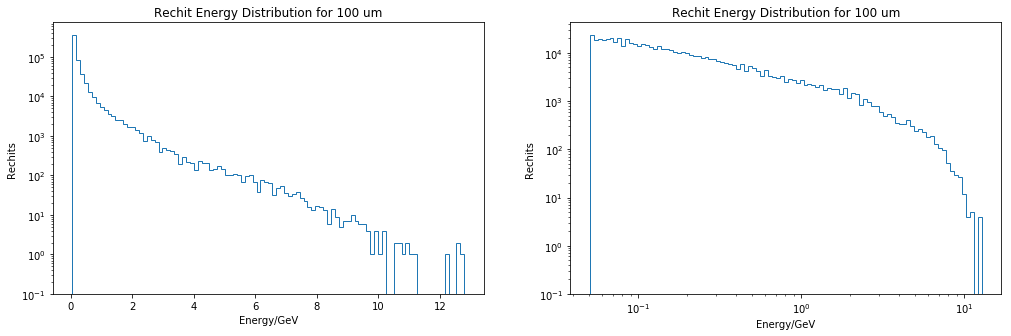

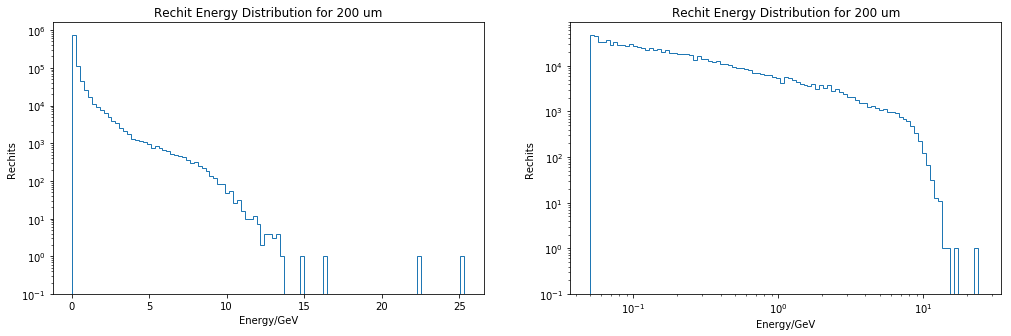

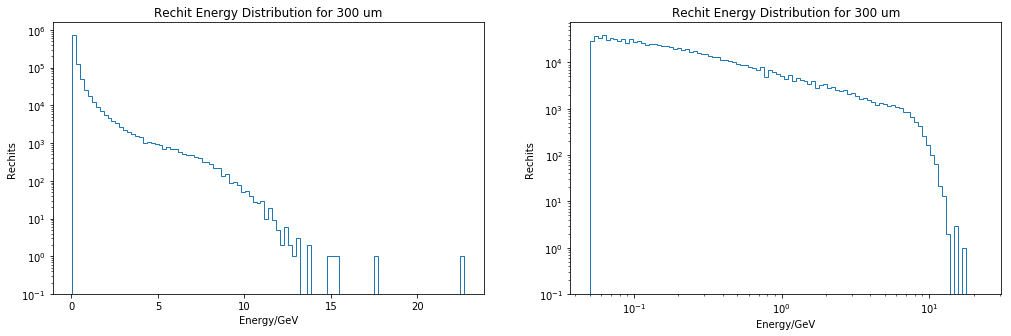

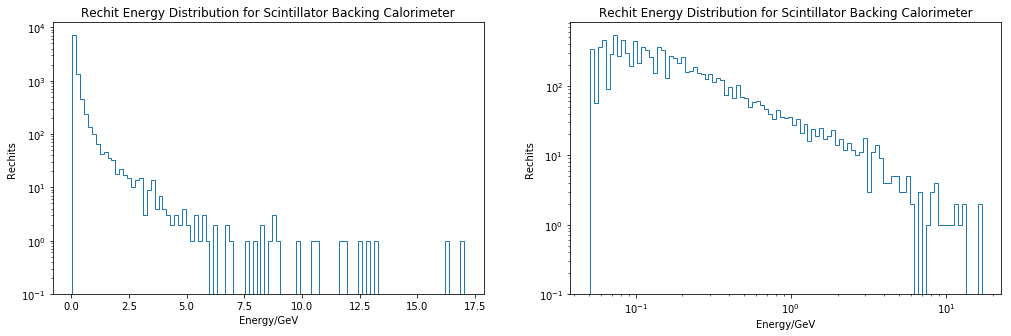

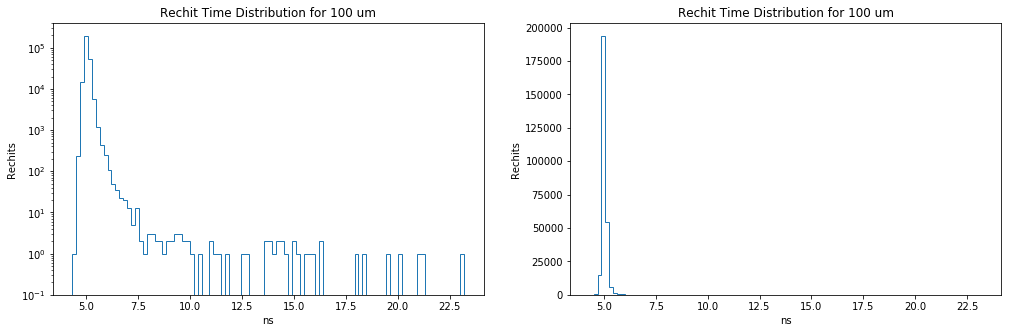

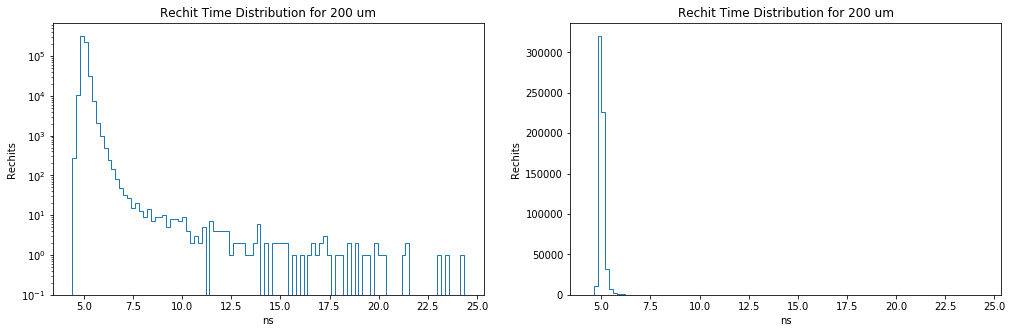

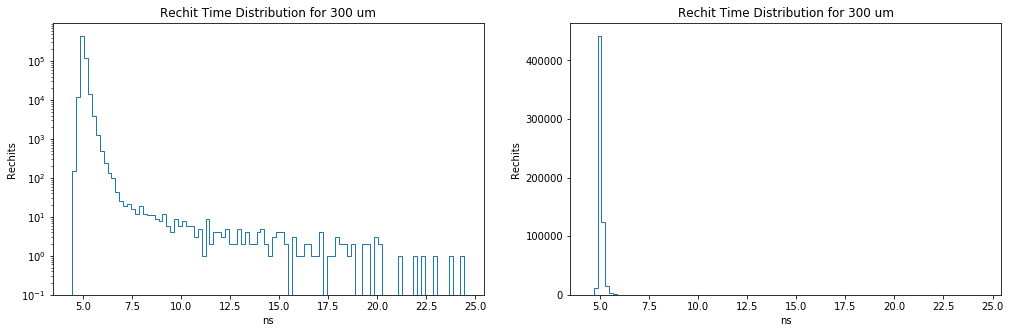

In [26]:
figs.append(plotRechitEnergy_Thickness(100, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(200, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(300, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, rechit[b'rechit_energy'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitTime_Thickness(100, rechit[b'rechit_time'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitTime_Thickness(200, rechit[b'rechit_time'], rechit[b'rechit_thickness'], "Rechit"));
figs.append(plotRechitTime_Thickness(300, rechit[b'rechit_time'], rechit[b'rechit_thickness'], "Rechit"));


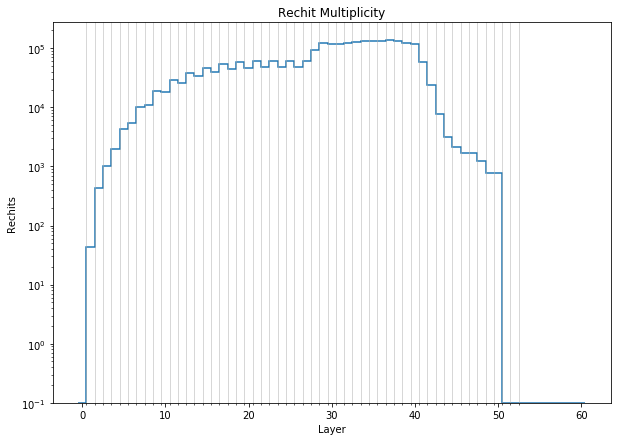

In [27]:
figs.append(plotHist_layers(rechit[b'rechit_layer'].content, "Rechits", "Rechit Multiplicity"))


In [28]:
def plotRechitDistribution_Layers(rechit_layer, rechit_pos, title_target):
    fig,axes = plt.subplots(figsize=(12, 7));
    axes.set_xlabel("Layer")
    axes.set_ylabel("%s" % (title_target))
    axes.set_xticks(np.arange(53)+0.5, minor=True)
    axes.set_title("%s distribution in Layers" % (title_target))
    h = axes.hist2d(rechit_layer.content, rechit_pos.content, bins=(np.arange(62)-0.5, 500), range=((-0.5,60.5),(-250.0, 250.0)), norm=mpl.colors.LogNorm());
    plt.grid(True, which='minor', axis='x', linewidth='0.5')
    plt.colorbar(h[3], ax=axes);
    return fig

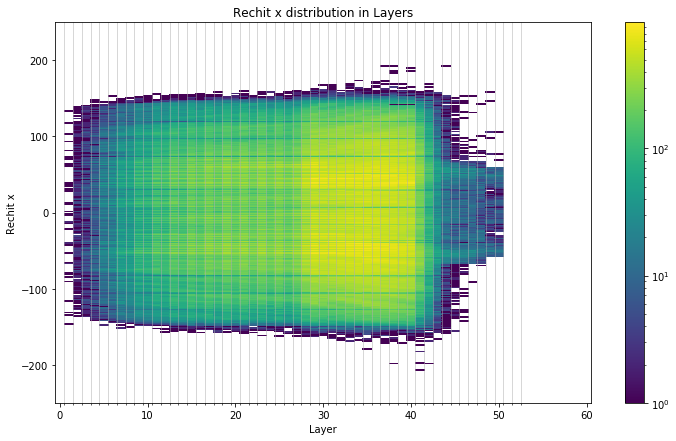

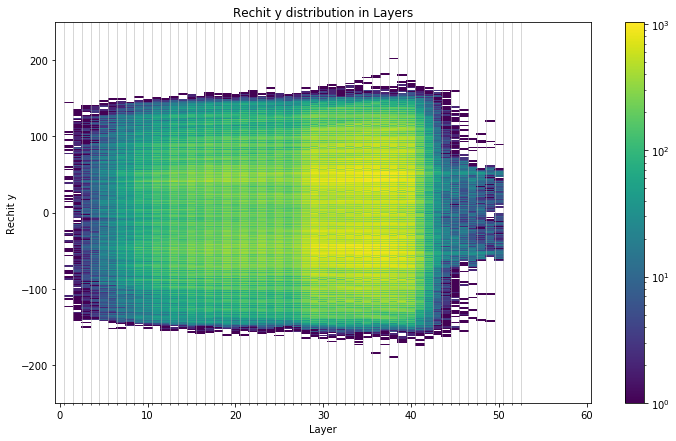

In [29]:
figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_x'], 'Rechit x'));
figs.append(plotRechitDistribution_Layers(rechit[b'rechit_layer'], rechit[b'rechit_y'], 'Rechit y'));

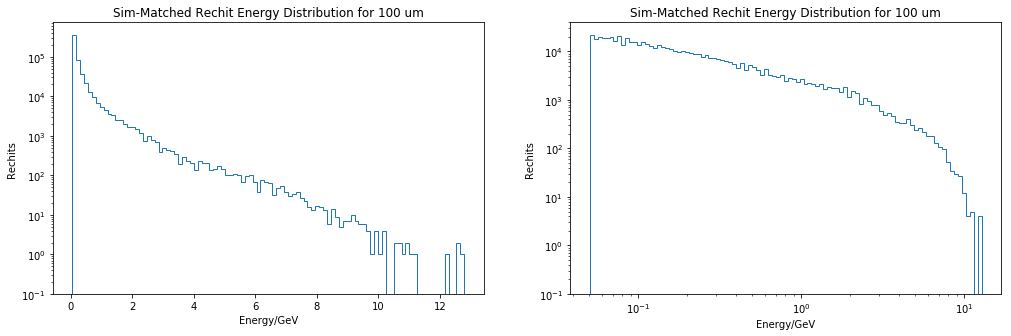

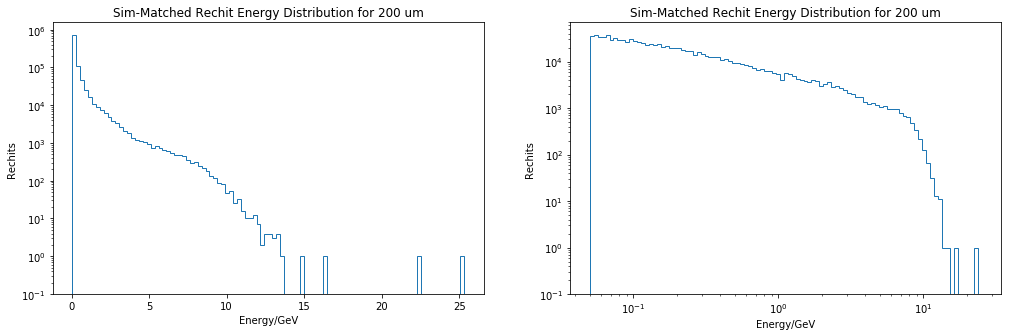

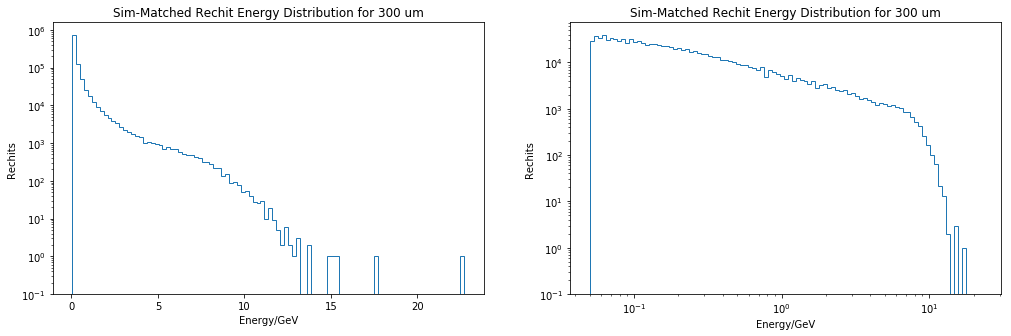

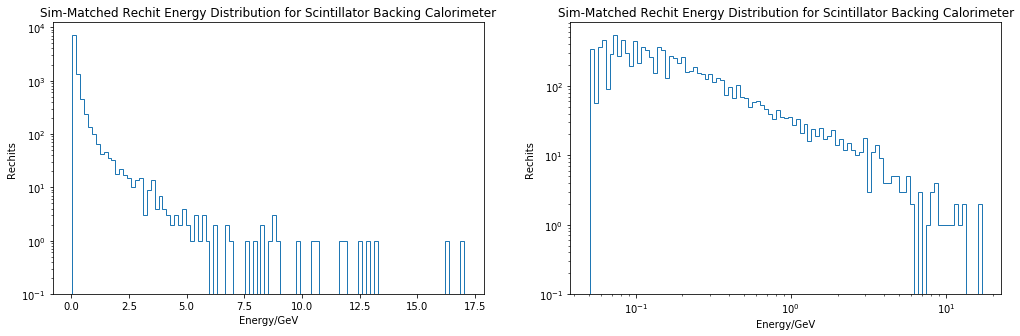

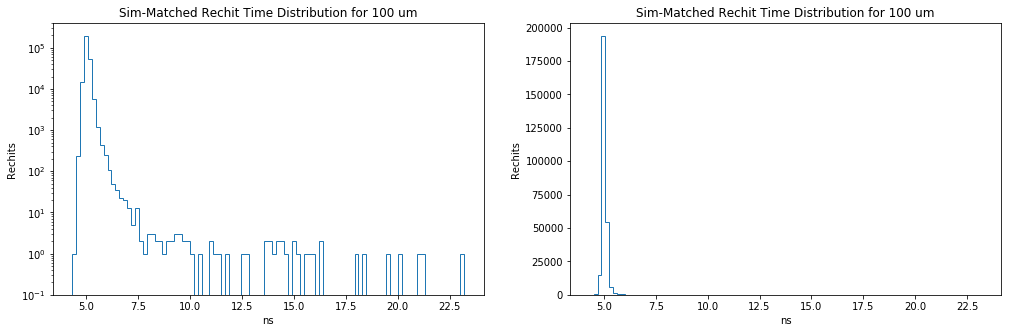

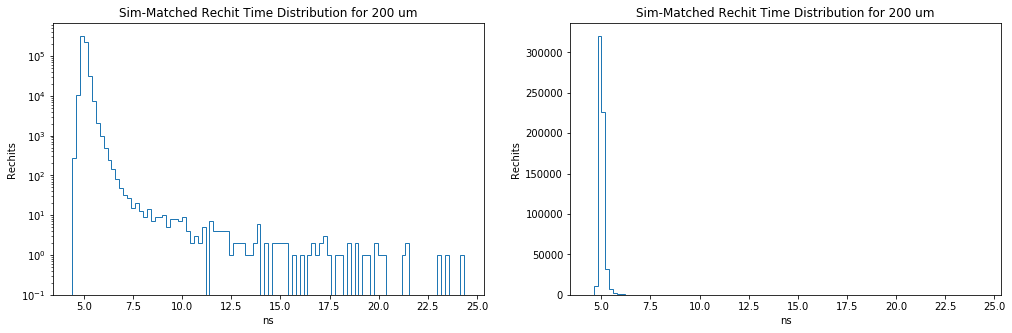

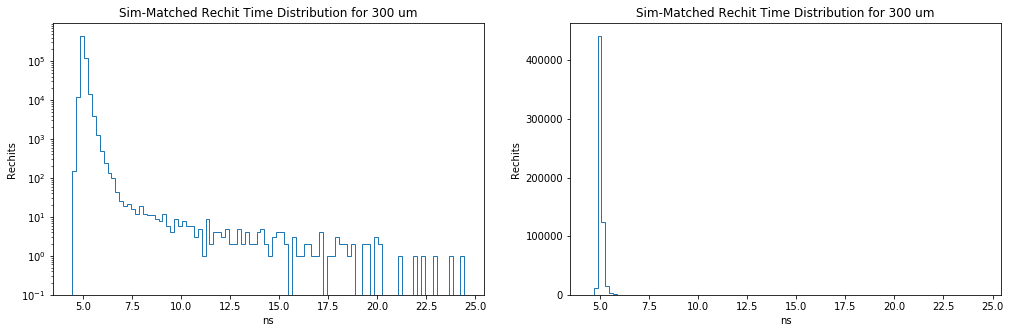

In [30]:
figs.append(plotRechitEnergy_Thickness(100, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(200, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(300, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitEnergy_Thickness(-1, simmatched_rechit[b'rechit_energy'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitTime_Thickness(100, simmatched_rechit[b'rechit_time'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitTime_Thickness(200, simmatched_rechit[b'rechit_time'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));
figs.append(plotRechitTime_Thickness(300, simmatched_rechit[b'rechit_time'], simmatched_rechit[b'rechit_thickness'], "Sim-Matched Rechit"));


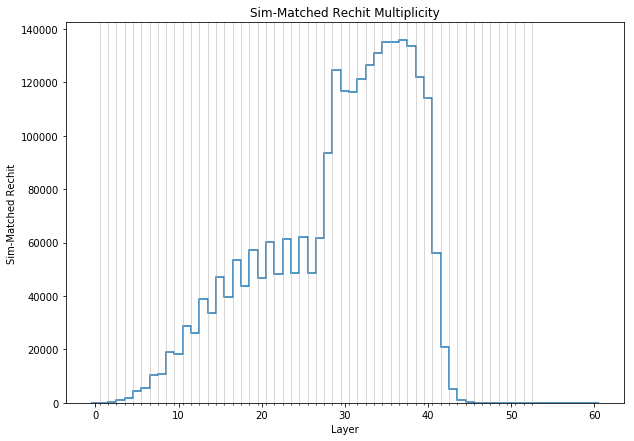

In [31]:
figs.append(plotHist_layers(simmatched_rechit[b'rechit_layer'].content, "Sim-Matched Rechit",\
                            "Sim-Matched Rechit Multiplicity", log=False))

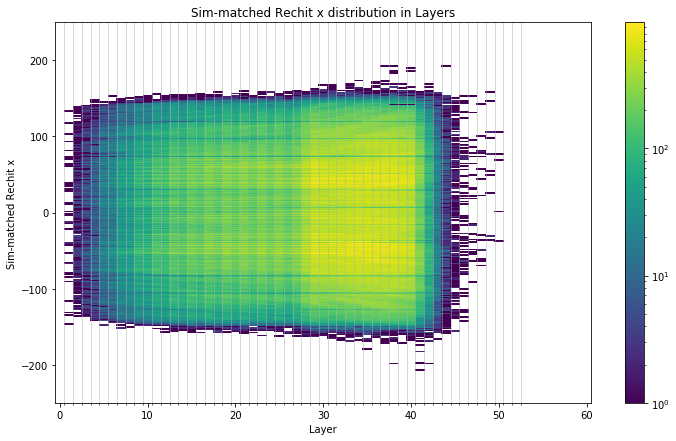

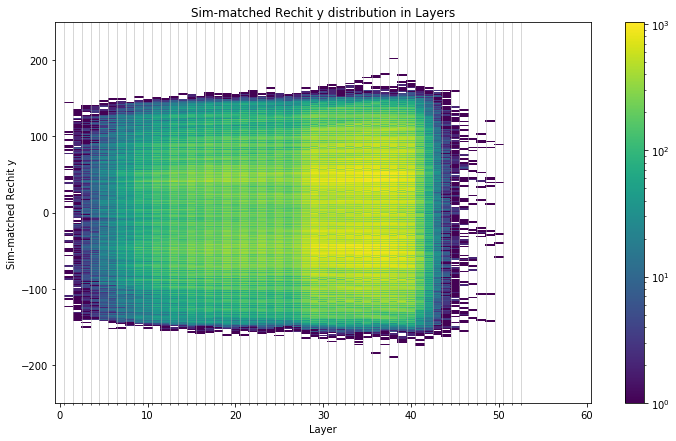

In [32]:
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_x'], 'Sim-matched Rechit x'));
figs.append(plotRechitDistribution_Layers(simmatched_rechit[b'rechit_layer'], simmatched_rechit[b'rechit_y'], 'Sim-matched Rechit y'));

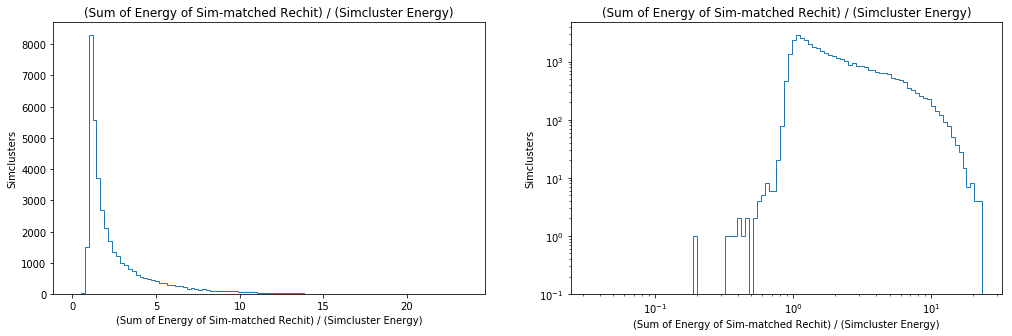

In [33]:
h = np.divide(corrected_rechit_simcluster_energy.flatten().sum(), simcluster[b'simcluster_energy'].flatten())
#h = np.divide(rechit_simcluster[b'rechit_energy'].flatten().sum(), simcluster[b'simcluster_energy'].flatten())

fig = plt.figure(figsize=(17,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", "Simclusters",\
         "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", Nbins = 100)
ax2 = fig.add_subplot(122);
plotHist(ax2, h, "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", "Simclusters",\
         "(Sum of Energy of Sim-matched Rechit) / (Simcluster Energy)", Nbins = 100, xlog=True, ylog=True)
figs.append(fig)

In [34]:
eta_barycentre = np.divide((corrected_rechit_simcluster_energy.content * rechit_simcluster[b'rechit_eta'].content).sum(), \
                            corrected_rechit_simcluster_energy.content.sum())

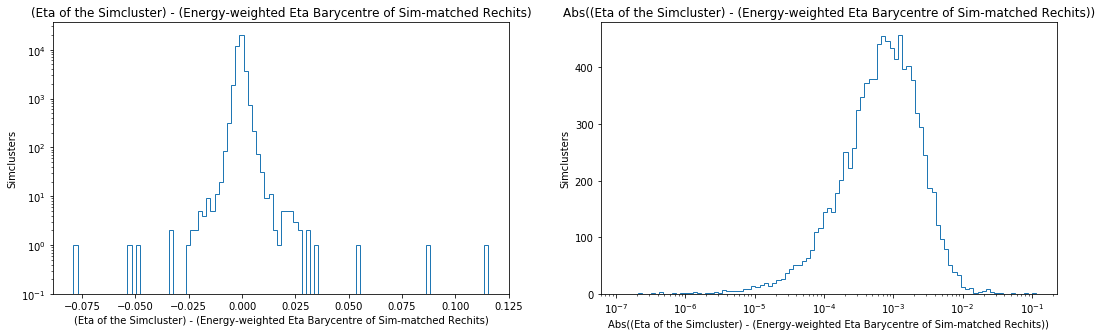

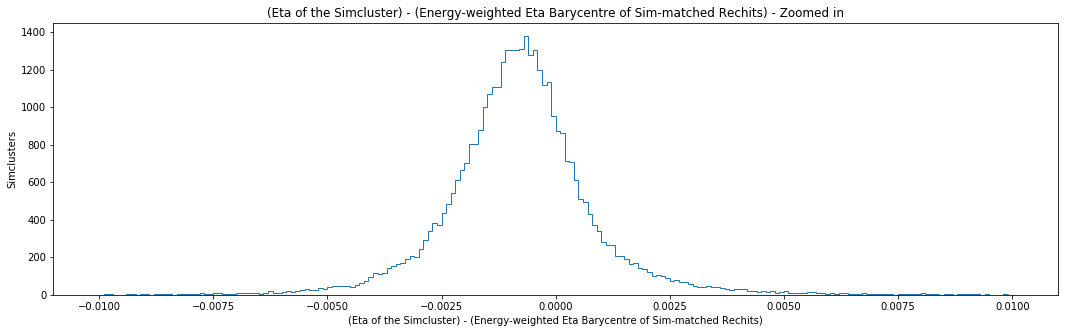

In [35]:
h = simcluster[b'simcluster_eta'].content - eta_barycentre

fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        "Simclusters", "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        Nbins=100, ylog=True)
ax2 = fig.add_subplot(122);
plotHist_absxlog(ax2, h, "Abs((Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits))",\
        "Simclusters", "Abs((Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits))",\
        Nbins=100)
figs.append(fig)

fig, axes = plt.subplots(figsize=(18,5));
plotHist(axes, h, "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits)",\
        "Simclusters", "(Eta of the Simcluster) - (Energy-weighted Eta Barycentre of Sim-matched Rechits) - Zoomed in",\
        Nbins=200, range=(-0.01, 0.01))
figs.append(fig)


In [36]:
phi_barycentre = np.divide((corrected_rechit_simcluster_energy.content * rechit_simcluster[b'rechit_phi'].content).sum(), \
                            corrected_rechit_simcluster_energy.content.sum())

/Users/saptaparnabhattacharya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/saptaparnabhattacharya/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:159: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/saptaparnabhattacharya/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/Users/saptaparnabhattacharya/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:421: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


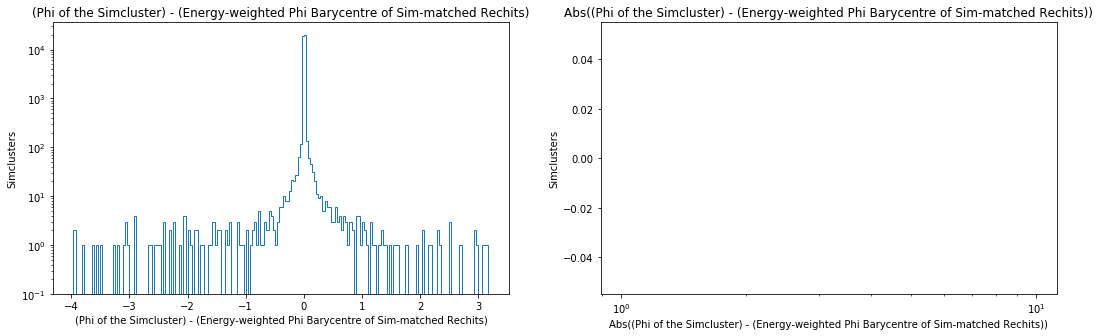

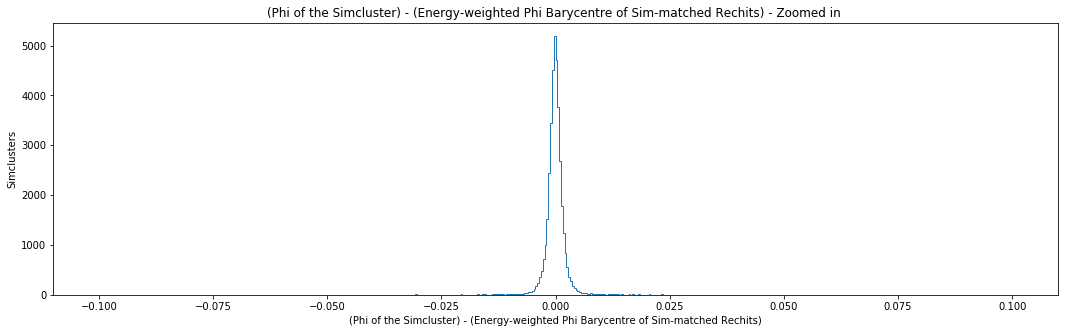

In [37]:
h = simcluster[b'simcluster_phi'].content - phi_barycentre
fig = plt.figure(figsize=(18,5));
ax1 = fig.add_subplot(121);
plotHist(ax1, h, "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", "Simclusters",\
        "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", Nbins=200, ylog=True)
ax2 = fig.add_subplot(122);
plotHist_absxlog(ax2, h, "Abs((Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits))",\
                 "Simclusters",\
                 "Abs((Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits))", Nbins=200)
figs.append(fig)

fig, axes = plt.subplots(figsize=(18,5));
plotHist(axes, h, "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits)", "Simclusters",\
        "(Phi of the Simcluster) - (Energy-weighted Phi Barycentre of Sim-matched Rechits) - Zoomed in ",\
         range= (-0.1, 0.1), Nbins=500)
figs.append(fig)


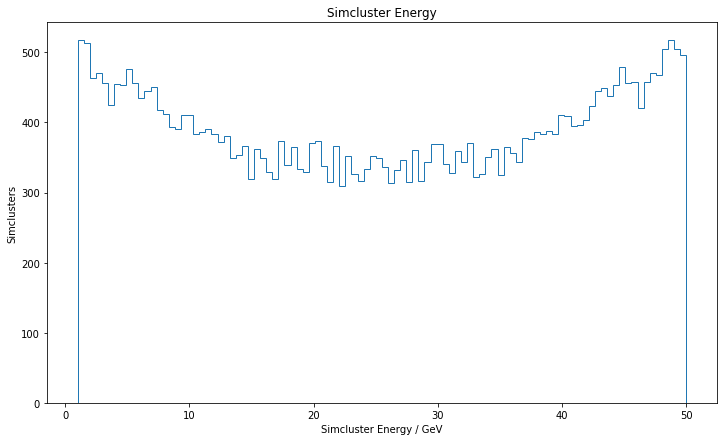

In [38]:
h = simcluster[b'simcluster_energy'].content
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, h, "Simcluster Energy / GeV", "Simclusters", "Simcluster Energy", Nbins=100)
figs.append(fig)


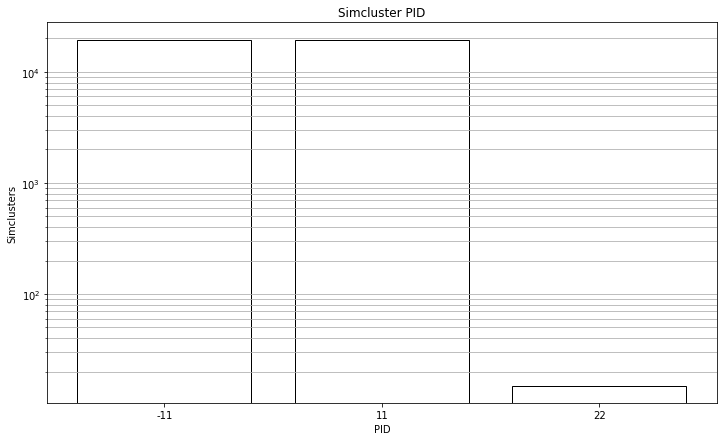

In [39]:
x, y = np.unique(simcluster[b'simcluster_pid'].flatten(), return_counts=True)
x_pos = np.arange(len(x))
fig,axes = plt.subplots(figsize=(12, 7));
axes.bar(x_pos, y, log=True, fill=False)
axes.set_xticks(x_pos)
axes.set_xticklabels(x)
axes.set_title("Simcluster PID")
axes.set_xlabel("PID")
axes.set_ylabel("Simclusters")
plt.grid(True, which='both', axis='y')
figs.append(fig)

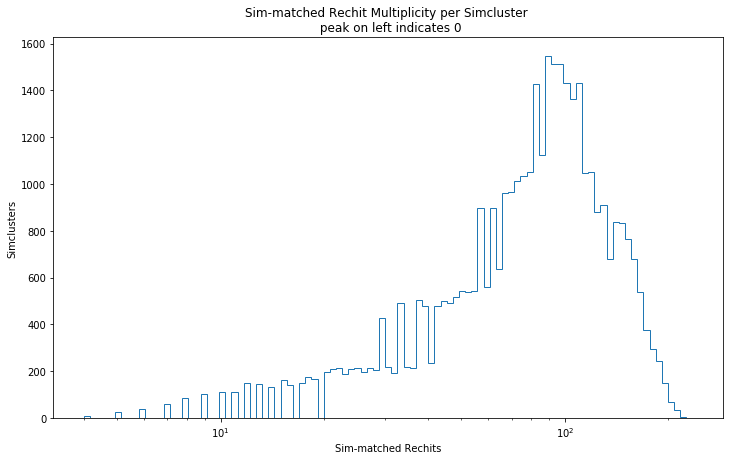

In [40]:
fig,axes = plt.subplots(figsize=(12, 7));
plotHist(axes, valid_sim_indices.flatten().counts+0.01, "Sim-matched Rechits", "Simclusters",\
         "Sim-matched Rechit Multiplicity per Simcluster \n peak on left indicates 0", Nbins = 100 ,xlog=True)
figs.append(fig)

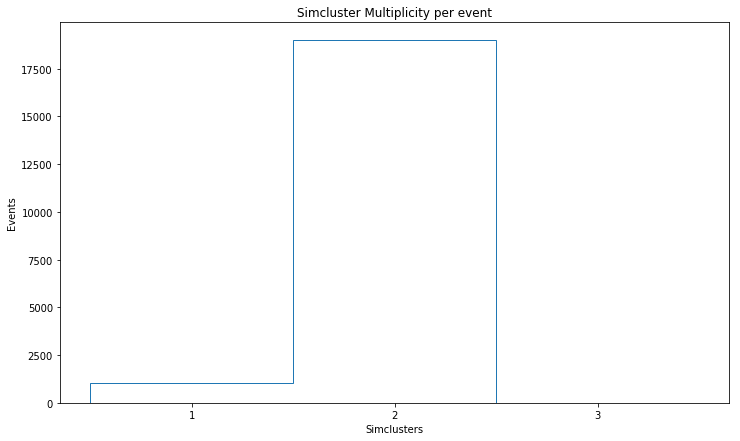

In [41]:
fig,axes = plt.subplots(figsize=(12, 7));
h= valid_sim_indices.counts
plotHist(axes, h, "Simclusters", "Events",\
         "Simcluster Multiplicity per event", Nbins = np.arange(h.min()-0.5,h.max()+1.5,1))
axes.set_xticks(np.arange(h.min(),h.max()+1,1), minor=False)
figs.append(fig)

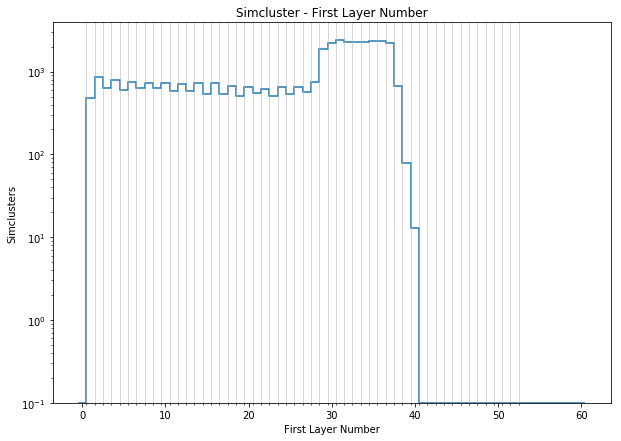

In [42]:
h = simcluster[b'simcluster_layers'].content.min()
figs.append(plotHist_layers(h, "Simclusters", "Simcluster - First Layer Number", xlabel= "First Layer Number"))

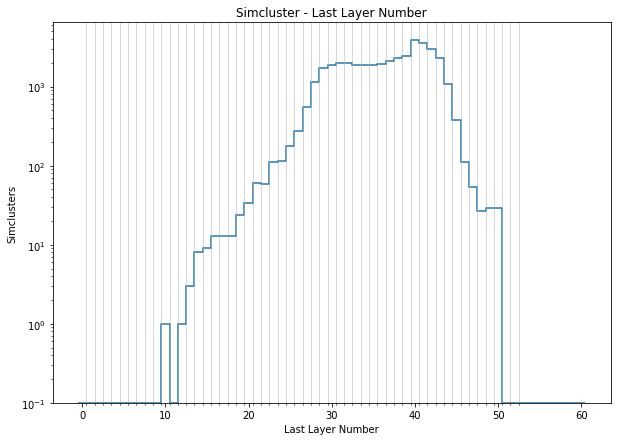

In [43]:
h = simcluster[b'simcluster_layers'].content.max()
figs.append(plotHist_layers(h, "Simclusters", "Simcluster - Last Layer Number", xlabel= "Last Layer Number"))

In [44]:
import matplotlib.backends.backend_pdf
outname = 'validation_ntup_' + fname.rstrip('.root').split('/')[-1] +'.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(outname)
for fig in figs: 
    pdf.savefig(fig)
pdf.close()